In [1]:
import mat4py
import numpy as np
from sklearn.decomposition import FastICA
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

Using TensorFlow backend.


In [2]:
ms = 500

In [3]:
import mat4py

X2 = mat4py.loadmat('sub2_comp.mat')

In [4]:
train_dg = np.array(X2['train_dg'])
y2 = train_dg[ms:].reshape(train_dg.shape[0]-ms, train_dg.shape[1])

In [5]:
def filter_elec_noise(w0, Q, fs, data):
    from scipy.signal import iirnotch, lfilter
    
    # changes data from a list of arrays to a 2-D array
    # makes it easier to work with
    adjusted_array = np.stack(data[:])
    
    # initialize finalized array
    filtered_data = np.empty_like(adjusted_array)
    
    # parameters are w0 - freq. to remove, Q - quality, fs - sampling frequency of system
    b, a = iirnotch(w0, Q, fs)
    
    # application of filter to data
    for channel in range(adjusted_array.shape[1]): #48 channels
        denoised_channel = lfilter(b, a, adjusted_array[:,channel])
        for timepoint in range(adjusted_array.shape[0]): #400000 timepoints for training
            filtered_data[timepoint][channel] = denoised_channel[timepoint]
            
    return filtered_data, adjusted_array
            
            
X2_filtered, adjusted_array = filter_elec_noise(60.0, 60.0, 1000, X2['train_data'])

In [6]:
def kurtosis_check(data, icaSignal):
    kurtosis_stat = []
    for channel in range(data.shape[1]):
        kurtosis_stat.append(stats.kurtosis(icaSignal[:,channel]))
    
    avg = np.mean(kurtosis_stat)
    
    kurt_stat_np = np.asarray(kurtosis_stat)

    too_high = kurt_stat_np > (5 * avg)  

    icaSignal[:,too_high] = 0

    return icaSignal

In [7]:
def ica_drop_artifact(data):
    
    ica = FastICA(n_components=48,max_iter=300)
    icaSignal = ica.fit_transform(data)
    
    kurtosis_check(data, icaSignal)
    
    ica_data = ica.inverse_transform(icaSignal)
    
    fig, axes = plt.subplots(6, 8, figsize=(16, 16))
    for row in range(6):
        for col in range(8):
            axes[row][col].plot(icaSignal[:,(8*row)+col])
            
    return ica_data

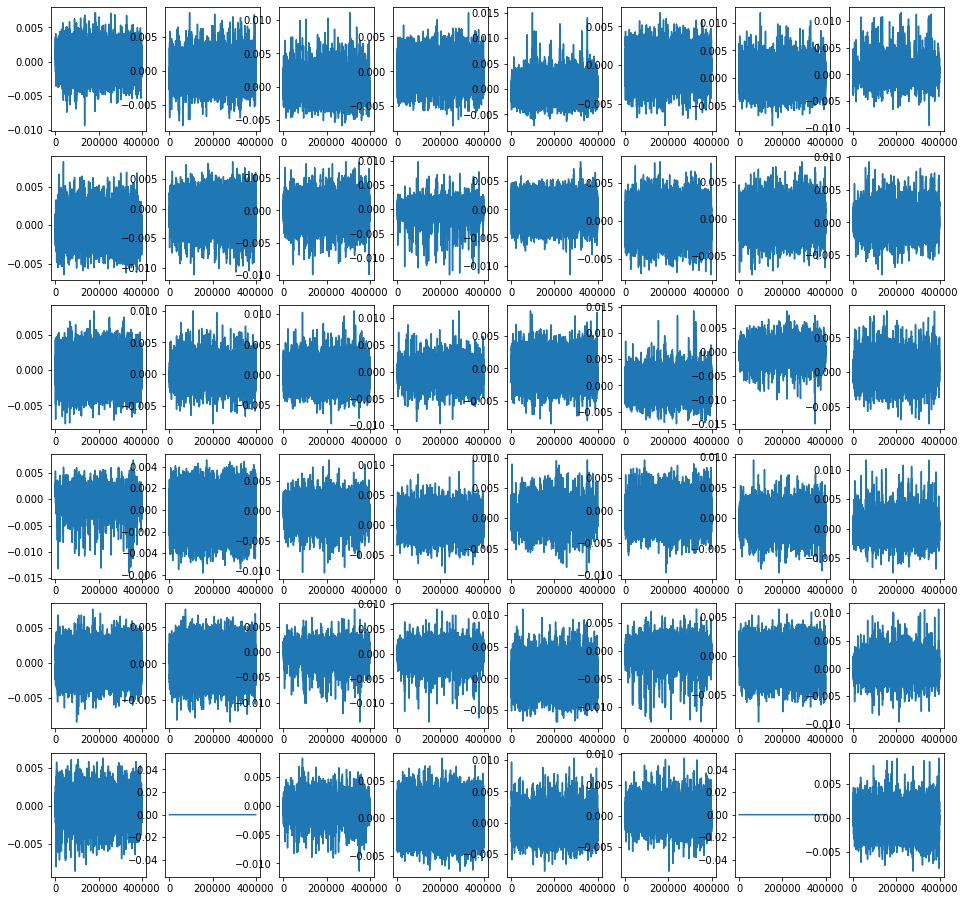

In [8]:
X2_filt_ica = ica_drop_artifact(X2_filtered)

In [9]:
def create_time_features(data, ms):
    
    mav_eeg = np.zeros((data.shape[0] - ms, 48))
    
    for timestep in range(mav_eeg.shape[0]):
        if timestep%3999 == 0:
            print(f'- {timestep/3999}% for mav')
        for channel in range(mav_eeg.shape[1]):
            mav_eeg[timestep, channel] = np.mean(data[timestep:timestep+ms, channel])
        
    peak_eeg = np.zeros((data.shape[0] - ms, 48))

    for timestep in range(peak_eeg.shape[0]):
        if timestep%3999 == 0:
            print(f'- {timestep/3999}% for peak')
        for channel in range(peak_eeg.shape[1]):
            peak_eeg[timestep, channel] = np.amax(data[timestep:timestep+ms, channel])
    
    std_eeg = np.zeros((data.shape[0] - ms, 48))

    for timestep in range(std_eeg.shape[0]):
        if timestep%3999 == 0:
            print(f'- {timestep/3999}% for std')
        for channel in range(std_eeg.shape[1]):
            std_eeg[timestep, channel] = np.std(data[timestep:timestep+ms, channel])
                
    return mav_eeg, peak_eeg, std_eeg
    

In [10]:
mav_eeg, peak_eeg, std_eeg = create_time_features(X2_filt_ica, ms)

- 0.0% for mav
- 1.0% for mav
- 2.0% for mav
- 3.0% for mav
- 4.0% for mav
- 5.0% for mav
- 6.0% for mav
- 7.0% for mav
- 8.0% for mav
- 9.0% for mav
- 10.0% for mav
- 11.0% for mav
- 12.0% for mav
- 13.0% for mav
- 14.0% for mav
- 15.0% for mav
- 16.0% for mav
- 17.0% for mav
- 18.0% for mav
- 19.0% for mav
- 20.0% for mav
- 21.0% for mav
- 22.0% for mav
- 23.0% for mav
- 24.0% for mav
- 25.0% for mav
- 26.0% for mav
- 27.0% for mav
- 28.0% for mav
- 29.0% for mav
- 30.0% for mav
- 31.0% for mav
- 32.0% for mav
- 33.0% for mav
- 34.0% for mav
- 35.0% for mav
- 36.0% for mav
- 37.0% for mav
- 38.0% for mav
- 39.0% for mav
- 40.0% for mav
- 41.0% for mav
- 42.0% for mav
- 43.0% for mav
- 44.0% for mav
- 45.0% for mav
- 46.0% for mav
- 47.0% for mav
- 48.0% for mav
- 49.0% for mav
- 50.0% for mav
- 51.0% for mav
- 52.0% for mav
- 53.0% for mav
- 54.0% for mav
- 55.0% for mav
- 56.0% for mav
- 57.0% for mav
- 58.0% for mav
- 59.0% for mav
- 60.0% for mav
- 61.0% for mav
- 62.0% for mav
- 

In [11]:
def feature_scaler(mav, peak, std):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    mav = scaler.fit_transform(mav)
    peak = scaler.fit_transform(peak)
    std = scaler.fit_transform(std)

    mav_eeg_reshaped = mav.reshape(mav.shape[0], 1, mav.shape[1])
    peak_eeg_reshaped = peak.reshape(peak.shape[0], 1, peak.shape[1])
    std_eeg_reshaped = std.reshape(std.shape[0], 1, std.shape[1])
    
    feature_vector = np.concatenate((mav_eeg_reshaped, peak_eeg_reshaped), axis = 2)
    feature_vector = np.concatenate((feature_vector, std_eeg_reshaped), axis = 2)
    
    return feature_vector

In [12]:
time_feat_vector = feature_scaler(mav_eeg, peak_eeg, std_eeg)

In [13]:
import copy

y2threshold = copy.deepcopy(y2)

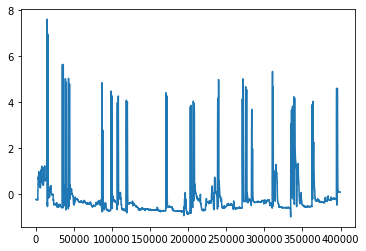

In [14]:
plt.plot(y2threshold[:,0])

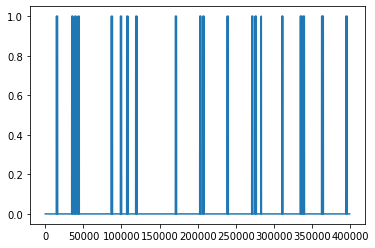

In [15]:
y2threshold[:,0] = [1 if x >= 2 else 0 for x in y2[:,0]]
plt.plot(y2threshold[:,0])

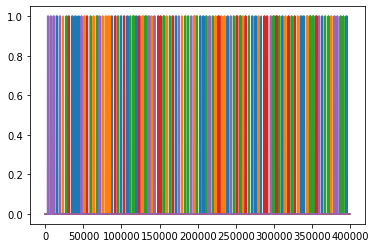

In [223]:
for channel in range(5):
    y2threshold[:,channel] = [1 if x >= 2.5 else 0 for x in y2[:,channel]]
    plt.plot(y2threshold[:,channel])

In [224]:
not_moving = (y2threshold[:,0]+y2threshold[:,1]+y2threshold[:,2]+y2threshold[:,3]+y2threshold[:,4])

In [225]:
not_moving_threshold = [0 if x > 0 else 1 for x in not_moving]

In [226]:
y2_full = np.concatenate((y2threshold, np.array(not_moving_threshold).reshape(len(not_moving_threshold), 1)), axis = 1)

In [330]:
y2_full.shape, time_feat_vector.shape

((399500, 6), (399500, 1, 144))

In [429]:
from keras import optimizers 
from keras.layers import Activation
from keras.callbacks import EarlyStopping

eeg_to_finger_model = Sequential()

eeg_to_finger_model.add(LSTM(8, return_sequences=True))
# eeg_to_finger_model.add(LSTM(32, return_sequences=True))
eeg_to_finger_model.add(LSTM(8))
eeg_to_finger_model.add(Dense(25))
eeg_to_finger_model.add(Dense(6, activation='softmax'))


eeg_to_finger_model.compile(loss='kld', optimizer='adam', metrics=['accuracy'])

In [430]:
weights = {0: 1/5.05 , 1: 1/5.05 , 2: 1/5.05 , 3: 1/5.05 , 4: 1/5.05 , 5: 0.05/5.05}
eeg_to_finger_model.fit(time_feat_vector, y2_full, validation_split = 0.3, batch_size = 1000, epochs = 100, callbacks = [EarlyStopping(monitor='val_accuracy', patience=2)], class_weight = weights)
yhat = eeg_to_finger_model.predict_classes(time_feat_vector)
# plt.figure(figsize=(25,8))
# plt.plot(yhat)
# plt.plot(y2_full[:,1])
# plt.axvline(x=279860, linewidth = 8, color = 'k');

Train on 279650 samples, validate on 119850 samples
Epoch 1/100
279650/279650 [==============================] - 3s 12us/step - loss: 0.0701 - accuracy: 0.5383 - val_loss: 0.0829 - val_accuracy: 0.5987
Epoch 2/100
279650/279650 [==============================] - 2s 9us/step - loss: 0.0283 - accuracy: 0.7437 - val_loss: 0.1233 - val_accuracy: 0.6538
Epoch 3/100
279650/279650 [==============================] - 2s 8us/step - loss: 0.0141 - accuracy: 0.8190 - val_loss: 0.1523 - val_accuracy: 0.6822
Epoch 4/100
279650/279650 [==============================] - 3s 9us/step - loss: 0.0086 - accuracy: 0.8570 - val_loss: 0.1840 - val_accuracy: 0.7054
Epoch 5/100
279650/279650 [==============================] - 2s 8us/step - loss: 0.0059 - accuracy: 0.8872 - val_loss: 0.2070 - val_accuracy: 0.7267
Epoch 6/100
279650/279650 [==============================] - 2s 8us/step - loss: 0.0043 - accuracy: 0.9113 - val_loss: 0.2275 - val_accuracy: 0.7309
Epoch 7/100
279650/279650 [==========================

In [505]:
y2_graph = copy.deepcopy(y2_full)

In [506]:
y2_graph[:,1]

array([0., 0., 0., ..., 0., 0., 0.])

In [507]:
y2_graph[:,0] = [-1 if x == 0 else 0 for x in y2_graph[:,0]]
y2_graph[:,1] = [-1 if x == 0 else 1 for x in y2_graph[:,1]]
y2_graph[:,2] = [-1 if x == 0 else 2 for x in y2_graph[:,2]]
y2_graph[:,3] = [-1 if x == 0 else 3 for x in y2_graph[:,3]]
y2_graph[:,4] = [-1 if x == 0 else 4 for x in y2_graph[:,4]]

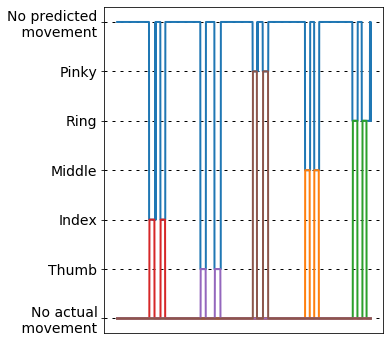

In [577]:
start = 232000
end = start+20000

plt.figure(figsize=(5, 6))
plt.plot(yhat[start:end], lw=2)
plt.plot(y2_graph[:,2][start:end], lw=2)
plt.plot(y2_graph[:,3][start:end], lw=2)
plt.plot(y2_graph[:,1][start:end], lw=2)
plt.plot(y2_graph[:,0][start:end], lw=2)
plt.plot(y2_graph[:,4][start:end], lw=2);
plt.yticks(np.arange(-1,6), ('No actual\n movement', 'Thumb', 'Index', 'Middle', 'Ring', 'Pinky', 'No predicted\n movement'), );
plt.yticks(fontsize=14)
plt.grid(axis='y', color='k', linestyle=(0,(3,5)), linewidth=1)
plt.xticks([]);


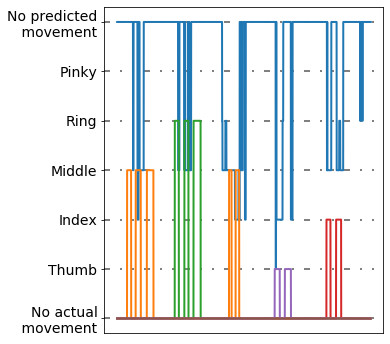

In [579]:
start = 298000
end = start+20000

plt.figure(figsize=(5,6))
plt.plot(yhat[start:end],lw=2)
plt.plot(y2_graph[:,2][start:end],lw=2)
plt.plot(y2_graph[:,3][start:end],lw=2)
plt.plot(y2_graph[:,1][start:end],lw=2)
plt.plot(y2_graph[:,0][start:end],lw=2)
plt.plot(y2_graph[:,4][start:end],lw=2)
plt.yticks(np.arange(-1,6), ('No actual\n movement', 'Thumb', 'Index', 'Middle', 'Ring', 'Pinky', 'No predicted\n movement'));
plt.yticks(fontsize=14)
plt.grid(axis='y', color='gray', linestyle=(0,(3,5,1,5,1,5)), linewidth=2)
plt.xticks([]);



In [433]:
from sklearn.metrics import classification_report, confusion_matrix

Y2_full = np.argmax(y2_full, axis=1)

print(classification_report(Y2_full[279650:], yhat[279650:]))



              precision    recall  f1-score   support

           0       0.29      0.22      0.25      4440
           1       0.12      0.24      0.16      3640
           2       0.20      0.20      0.20      6880
           3       0.13      0.13      0.13      4880
           4       0.28      0.20      0.24      3080
           5       0.89      0.88      0.88     96930

    accuracy                           0.75    119850
   macro avg       0.32      0.31      0.31    119850
weighted avg       0.76      0.75      0.75    119850



In [434]:
cm = confusion_matrix(yhat[279650:], Y2_full[279650:]) 

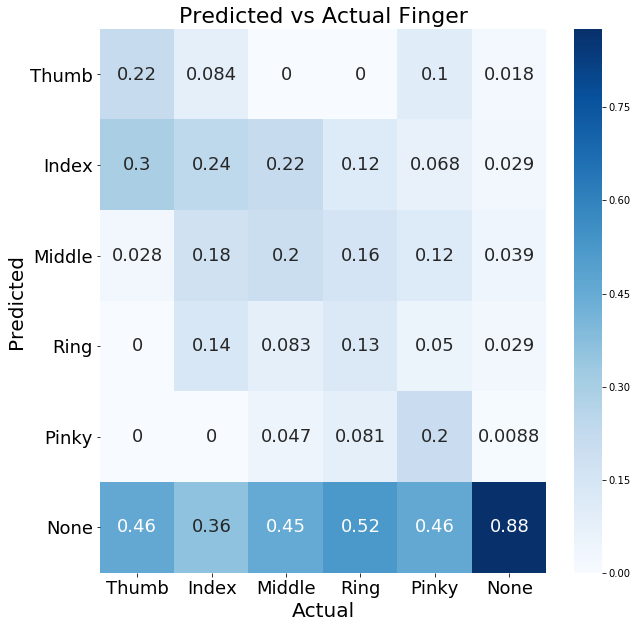

In [586]:
import seaborn as sns
    # create normalized confusion matrix <cm_nor>
cm_nor = np.zeros((cm.shape[0], cm.shape[1]))
for col in range(cm.shape[1]):
    cm_nor[:, col] = (cm[:, col] / sum(cm[:, col]))
plt.figure(figsize=(10,10)) 
plt.ylim(-10, 10)
    # create normalized confusion matrix heat map
sns.heatmap(cm_nor, cmap="Blues", annot=True, annot_kws={"size": 18})
locs, labels = plt.xticks()
plt.xticks(locs, ("Thumb", "Index", "Middle", "Ring", "Pinky", "None"))
plt.xticks(fontsize=18)
locs, labels = plt.yticks()
plt.yticks(locs, ("Thumb", "Index", "Middle", "Ring", "Pinky", "None"))
plt.yticks(fontsize=18,rotation=0)
plt.xlabel("Actual", fontsize=20)
plt.ylabel("Predicted", fontsize=20)
plt.title("Predicted vs Actual Finger", fontsize = 22)
    # known bug in matplotlib chops off a portion of the
    # top and bottom rows of heat maps.  This section of
    # code recovers the top and bottom limits and moves them
    # so that the map displays appropriately.
bottom, top = plt.ylim()
bottom += 0.5
top -= 0.5
plt.ylim(bottom, top)
plt.show()

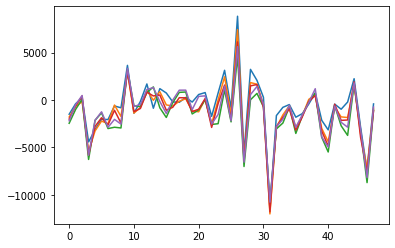

In [446]:
plt.plot(X2['train_data'][2]);
plt.plot(X2['train_data'][7]);
plt.plot(X2['train_data'][21]);
plt.plot(X2['train_data'][11]);
plt.plot(X2['train_data'][18]);

400000

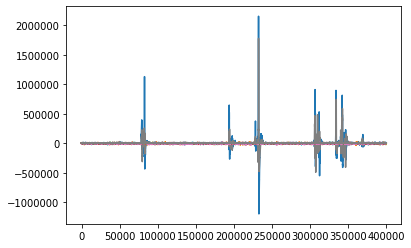

In [452]:
plt.plot(X2['train_data']);
len(X2['train_data'])

In [467]:
a = [[2, 4], [3, 5]]

In [494]:
a[0] = [x-1 if (x <= 2) else x for x in a[0]]
a[0]

[-8, 4]